In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random
import pandas as pd

file_path = r'C:\Users\n10766316\OneDrive - Queensland University of Technology\VRES\script files\burgers_numerical\burgers_numerical.csv'
df = pd.read_csv(file_path)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x
    
x_physics = torch.linspace(-1,1,30).view(-1,1).requires_grad_(True)
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)
nu = .01/np.pi

t_zero = torch.zeros_like(x_physics) # A zero vector the same shape as x

torch.manual_seed(42)
model = FCN(2,1,32,4)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

# Initial and boundary conditions

The domain of the problem is

$x\in[-1,1]$ and $t\in[0,1]$

The differential equation is 

$u_t+uu_x=\nu u_{xx}$

where $\nu$ is the viscosity and u is the wave velocity field.

The initial conditions are given as 

$u(x,0) = -sin(\pi x)$

$u(-1,t) = u(1,t) = 0$

In [2]:
def f_initial(x):
    return -torch.sin(np.pi*x)

def f_boundary(t):
    return 0*t

# Defining the boundary as 0 is a bit overkill but if it was a functional value
# it can be replaced there. Instead of just hard coding zero. 

# For initial condition loss
x_initial = torch.linspace(-1,1,30).view(-1,1)
t_initial = torch.zeros_like(x_physics)
xt_initial = torch.cat((x_initial, t_initial), dim=1)
u_initial = f_initial(x_initial)

# For boundary loss
t_boundary = torch.linspace(0,1,30).view(-1,1)
x_boundary = torch.ones_like(t_boundary)

t_boundary = torch.cat((t_boundary, t_boundary), dim=0)
x_boundary = torch.cat((x_boundary, -1 * x_boundary), dim=0)
xt_boundary = torch.cat((x_boundary, t_boundary), dim=1)
u_boundary = f_boundary(t_boundary)

# Tensors for physics-informed points
# x = torch.linspace(-1, 1, 30).view(-1,1).requires_grad_(True)
# t = torch.linspace(0, 1, 30).view(-1,1).requires_grad_(True)
# xt = torch.cat((x, t), dim=1)

seed = 42
random.seed(seed)
n = 2000
x = [random.uniform(-1, 1) for _ in range(n)]
t = [random.uniform(0, 1) for _ in range(n)]

x = torch.tensor(x).view(-1,1).requires_grad_(True)
t = torch.tensor(t).view(-1,1).requires_grad_(True)

xt = torch.cat((x, t), dim=1)
#plt.plot(xt.detach().numpy()[:,0], xt.detach().numpy()[:,1], 'k.')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_epochs = 50000

loss_history = [[],[]] # Epoch, loss
for i in range(n_epochs):
    optimizer.zero_grad()

    # Initial condition loss
    loss_i = torch.mean((u_initial- model(xt_initial)) ** 2)

    # Boundary condition loss
    loss_b = torch.mean((u_boundary - model(xt_boundary)) ** 2)

    # Physics-informed loss
    input_tensor = xt
    u_physics = model(input_tensor)
    u_x = torch.autograd.grad(u_physics, x, torch.ones_like(u_physics), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    u_t = torch.autograd.grad(u_physics, t, torch.ones_like(u_physics), create_graph=True)[0]
    loss_physics = torch.mean((u_t + u_physics * u_x - nu * u_xx) ** 2)

    # Backpropagate joint loss
    loss = loss_i + loss_b + loss_physics
    loss.backward()
    optimizer.step()

    if (i + 1) % 150 == 0:
        print('loss IC =', loss_i.detach().numpy(), 
              ', loss BC =', loss_b.detach().numpy(),
              ', loss Phys =', loss_physics.detach().numpy(),
              round(i / n_epochs * 100, 1), '%')
        loss_history[0].append(loss.detach().numpy())
        loss_history[1].append(i)

loss IC = 0.34983268 , loss BC = 0.046029497 , loss Phys = 0.0032425944 0.3 %
loss IC = 0.3342816 , loss BC = 0.048902616 , loss Phys = 0.0064500514 0.6 %
loss IC = 0.31369346 , loss BC = 0.042082887 , loss Phys = 0.01320014 0.9 %
loss IC = 0.24295944 , loss BC = 0.03203738 , loss Phys = 0.021443516 1.2 %
loss IC = 0.0992472 , loss BC = 0.006779371 , loss Phys = 0.0545993 1.5 %
loss IC = 0.08720345 , loss BC = 0.005035845 , loss Phys = 0.06134474 1.8 %
loss IC = 0.085890576 , loss BC = 0.0052021565 , loss Phys = 0.05939826 2.1 %
loss IC = 0.08501514 , loss BC = 0.0056286757 , loss Phys = 0.056983497 2.4 %
loss IC = 0.08367789 , loss BC = 0.005843444 , loss Phys = 0.0549696 2.7 %
loss IC = 0.08144694 , loss BC = 0.0055179396 , loss Phys = 0.053271584 3.0 %
loss IC = 0.07835641 , loss BC = 0.004791513 , loss Phys = 0.051228166 3.3 %
loss IC = 0.07479594 , loss BC = 0.0038088122 , loss Phys = 0.04868503 3.6 %
loss IC = 0.071301736 , loss BC = 0.0027037086 , loss Phys = 0.04620929 3.9 %
lo

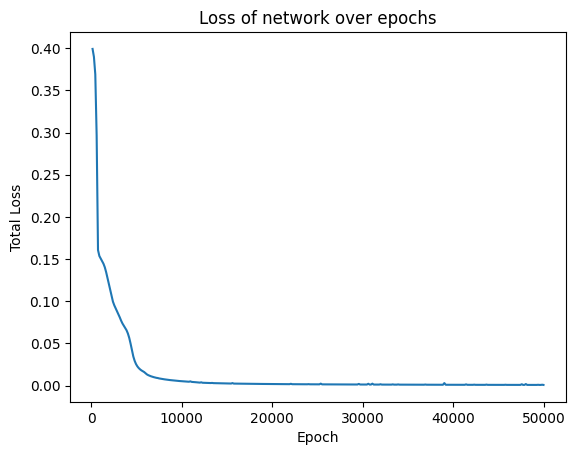

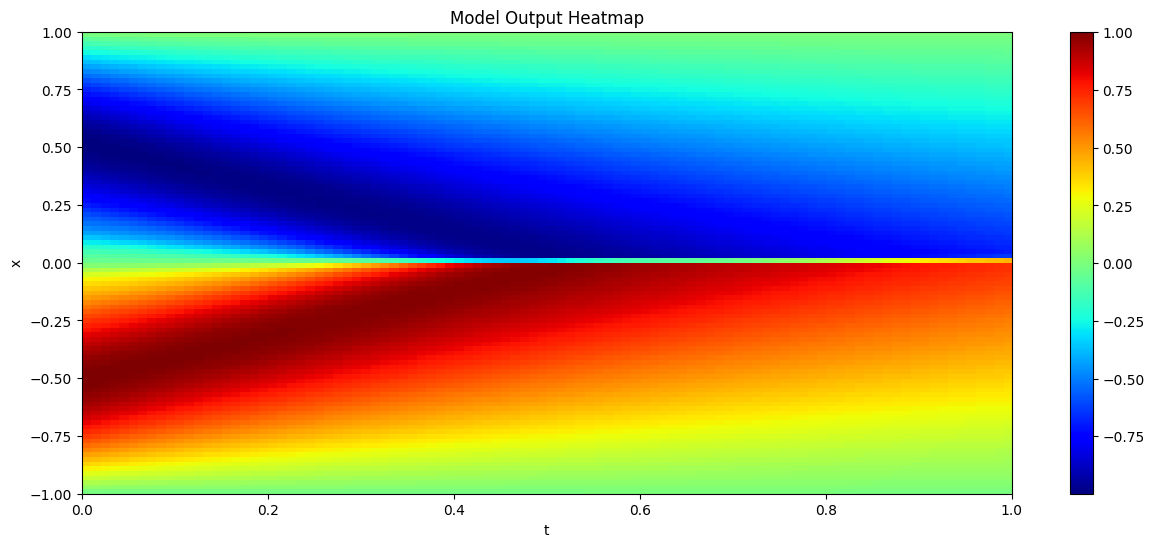

In [3]:
plt.figure()
plt.plot(loss_history[1], loss_history[0])
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Loss of network over epochs')

x = np.linspace(-1, 1, 100)
t = np.linspace(0, 1, 100)
X, T = np.meshgrid(x, t)
grid = np.vstack((X.ravel(), T.ravel())).T

grid_tensor = torch.tensor(grid, dtype=torch.float32)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(grid_tensor).numpy()

# Reshape and transpose the output for plotting as a heatmap
outputs_2d = outputs.reshape(X.shape).T  # Transpose the matrix

# Plotting as a heatmap
plt.figure(figsize=(15, 6))
plt.imshow(outputs_2d, extent=[t.min(), t.max(), x.min(), x.max()], origin='lower', cmap='jet', aspect='auto')
plt.colorbar()  # Add a color bar which maps values to colors

plt.xlabel('t')
plt.ylabel('x')
plt.title('Model Output Heatmap')
plt.show()

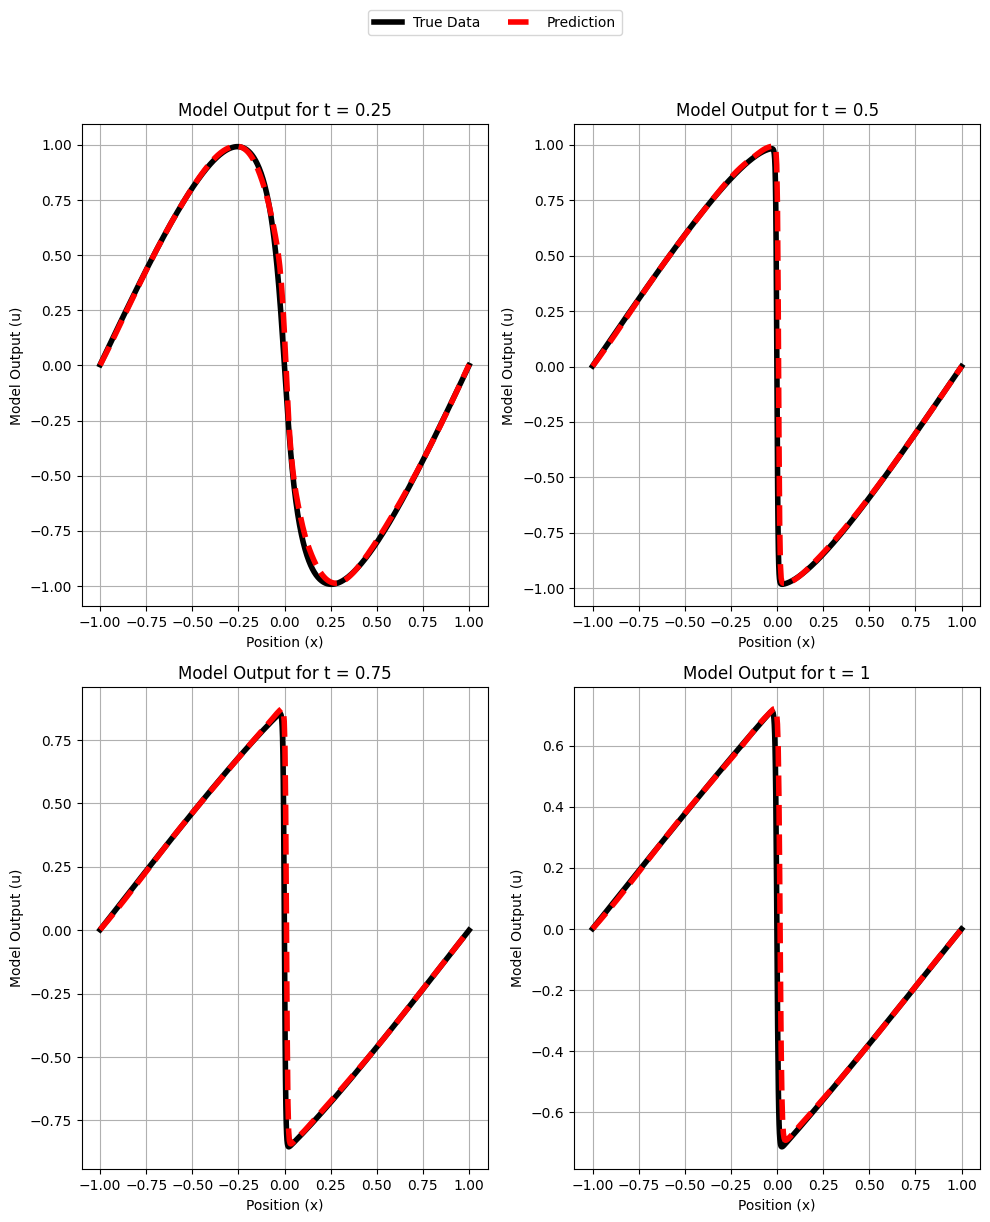

In [4]:
x = torch.linspace(-1, 1, 500)
time_values = [0.25, 0.5, 0.75, 1]
plt.figure(figsize=(10, 12))

# Need an x_vector for the numerical data because I didn't bring it over from matlab
n_numerical = len(df.iloc[:,1])
x_numerical = np.linspace(-1,1,n_numerical)

# plotting parameters
lw = 4

for i, constant_t in enumerate(time_values, 1):
    numerical_data = df.iloc[:, i-1]

    xt = torch.column_stack((x, torch.full_like(x, constant_t)))

    with torch.no_grad():
        u = model(xt)

    plt.subplot(2, 2, i)
    plt.plot(x_numerical, numerical_data, 'k', linewidth=lw)
    plt.plot(x.numpy(), u.numpy(), 'r--', linewidth=lw)
    plt.xlabel('Position (x)')
    plt.ylabel('Model Output (u)')
    plt.title(f'Model Output for t = {constant_t}')
    plt.grid(True)

# Create custom lines for the legend
true_line = mlines.Line2D([], [], color='black', linewidth=lw, label='True Data')
prediction_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=lw, label='Prediction')

# Place the legend outside the subplots
plt.figlegend(handles=[true_line, prediction_line], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to make room for the legend
plt.show()

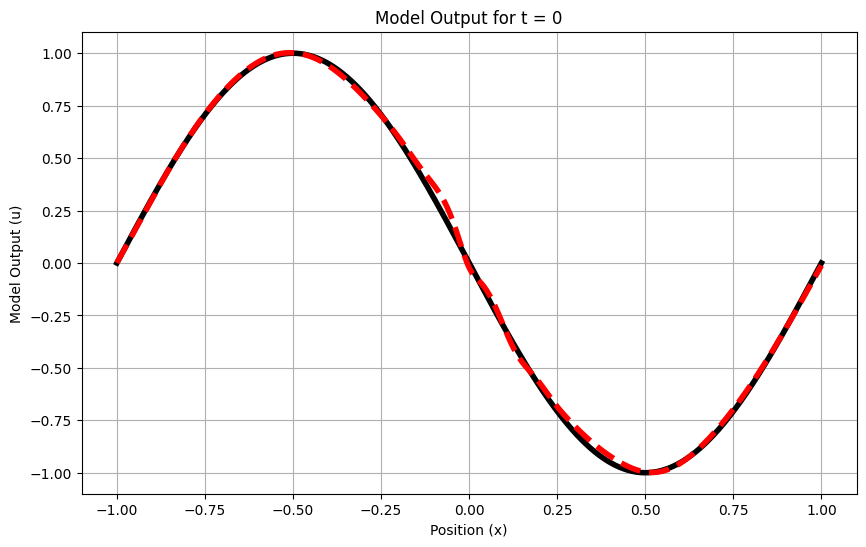

In [11]:
x = torch.linspace(-1, 1, 500)  

constant_t = 0 

xt = torch.column_stack((x, torch.full_like(x, constant_t)))

with torch.no_grad():
    u = model(xt)

plt.figure(figsize=(10, 6))
plt.plot(x.numpy(), -1*torch.sin(np.pi*x), 'k', linewidth=lw)
plt.plot(x.numpy(), u.numpy(), 'r--', linewidth=lw)
plt.xlabel('Position (x)')
plt.ylabel('Model Output (u)')
plt.title(f'Model Output for t = {constant_t}')
plt.grid(True)
plt.show()

In [6]:
x_test = torch.tensor([-.02,.02]).view(-1,1)
t_test = torch.tensor([1,1]).view(-1,1)
xt_test = torch.cat((x_test, t_test), dim=1)

model(xt_test)

print('max = ' + str(max(u.numpy())) + ', ' + 'min = ' + str(min(u.numpy())))

max = [0.7211009], min = [-0.69141555]


In [7]:
# Convert the notebook to a script
from functions import notebook_to_script
notebook_to_script('burgers_pinn.ipynb', 'burgers_pinn.py')